# Trabalho de Análise de Rede Complexas.

## Imports

In [ ]:
import requests
import gzip
import io
import json
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import community as community_louvain
from datetime import datetime, timedelta

## 1. Seleção/Coleta de Dados

- Coletando dados de arquivos do github.

In [ ]:
DATABASE_URL = "https://data.gharchive.org/"

def download_and_parse(url):

    r = requests.get(url)
    r.raise_for_status()

    compressed_file = io.BytesIO(r.content)

    with gzip.GzipFile(fileobj=compressed_file) as f:
        for line in f:
            yield json.loads(line)

def is_real_user(username):
    username = username.lower()
    bot_indicators = ["bot", "github-actions", "web-flow", "dependabot", "[bot]"]
    return not any(indicator in username for indicator in bot_indicators)

- Função para construir o grafo

In [ ]:
def build_graph(events):
    G = nx.Graph()
    repo_to_users = {}

    for e in events:
        if e.get("type") == "PushEvent":
            repo_name = e["repo"]["name"]
            user = e["actor"]["login"]
            if not is_real_user(user):
                continue

            if repo_name not in repo_to_users:
                repo_to_users[repo_name] = set()
            repo_to_users[repo_name].add(user)


    users_master = []

    for repo, users in repo_to_users.items():

        if len(users) < 3:
            continue

        users_list = list(users)

        users_master.append(users_list)

        for i in range(len(users_list)):
            for j in range(i+1, len(users_list)):
                u1 = users_list[i]
                u2 = users_list[j]

                if G.has_edge(u1, u2):
                    G[u1][u2]['weight'] += 1
                else:
                    G.add_edge(u1, u2, weight=1)
    
    with open('arquivo.json', 'w') as f:
        json.dump(users_master, f)
    return G


- Função para desenhar o grafo

In [ ]:
def draw_graph(graph, degrees):
    plt.figure(figsize=(12, 12))
    
    pos = nx.spring_layout(graph, k=0.1)

    node_sizes = [degrees[n] ** 2 for n in graph.nodes()]

    nx.draw_networkx_nodes(
        graph,
        pos,
        node_size=node_sizes,
        node_color="royalblue",
        alpha=0.8
    )

    nx.draw_networkx_edges(
        graph,
        pos,
        alpha=0.3
    )


- Função para carregar os graus

In [ ]:
def load_degrees(graph):
    degrees = dict(graph.degree())

    degree_to_users = {}

    for user, degree in degrees.items():
        if degree not in degree_to_users:
            degree_to_users[degree] = []

        degree_to_users[degree].append(user)

    return degree_to_users, degrees

## 2. Definição das questões de pesquisa

1. Quais desenvolvedores colaboram com mais frequência com outros em projetos públicos? -> Cód
2. Existem padrões visuais que indicam silos ou isolamento de certos grupos de desenvolvedores? -> Grafo
3. Existem padrões visuais que sugerem estrutura hierárquica, como redes em estrela, árvores ou galhos? -> Grafo
4. Existem desenvolvedores que funcionam como “ponte” entre grupos distintos? -> Grafo
5. Quais repositórios promovem mais colaboração entre usuários diferentes? -> Cód

## 3. Visualizações da rede

- Carregando o grafo e seus graus

In [ ]:
events = []

In [ ]:
for i in range(8,10):
    events_download = download_and_parse(DATABASE_URL+"2025-06-17-"+str(i)+".json.gz")
    events.extend(events_download)

In [ ]:
graph = build_graph(events)

degrees_to_user, degrees = load_degrees(graph)

### 1ª Visualização - Componentes conexos
- Isola e destaca o maior grupo de desenvolvedores conectados entre si.

In [ ]:
largest_cc = max(nx.connected_components(graph), key=len)
subgraph = graph.subgraph(largest_cc)

draw_graph(subgraph, degrees)
plt.title("Maior componente conexo da rede")
plt.savefig("./assets/maior_componente.png")

### 2ª Visualização - Subgrafo com os 20 nós mais conectados

In [ ]:
top_users = sorted(degrees.items(), key=lambda x: x[1], reverse=True)[:20]
top_usernames = [u for u, _ in top_users]
subgraph = graph.subgraph(top_usernames)

draw_graph(subgraph, degrees)
plt.title("Subgrafo: Top 20 desenvolvedores por grau")
plt.savefig("./assets/top20_grafo.png")

### 3ª Visualização - Rede com nós dimensionados pela centralidade (grau)

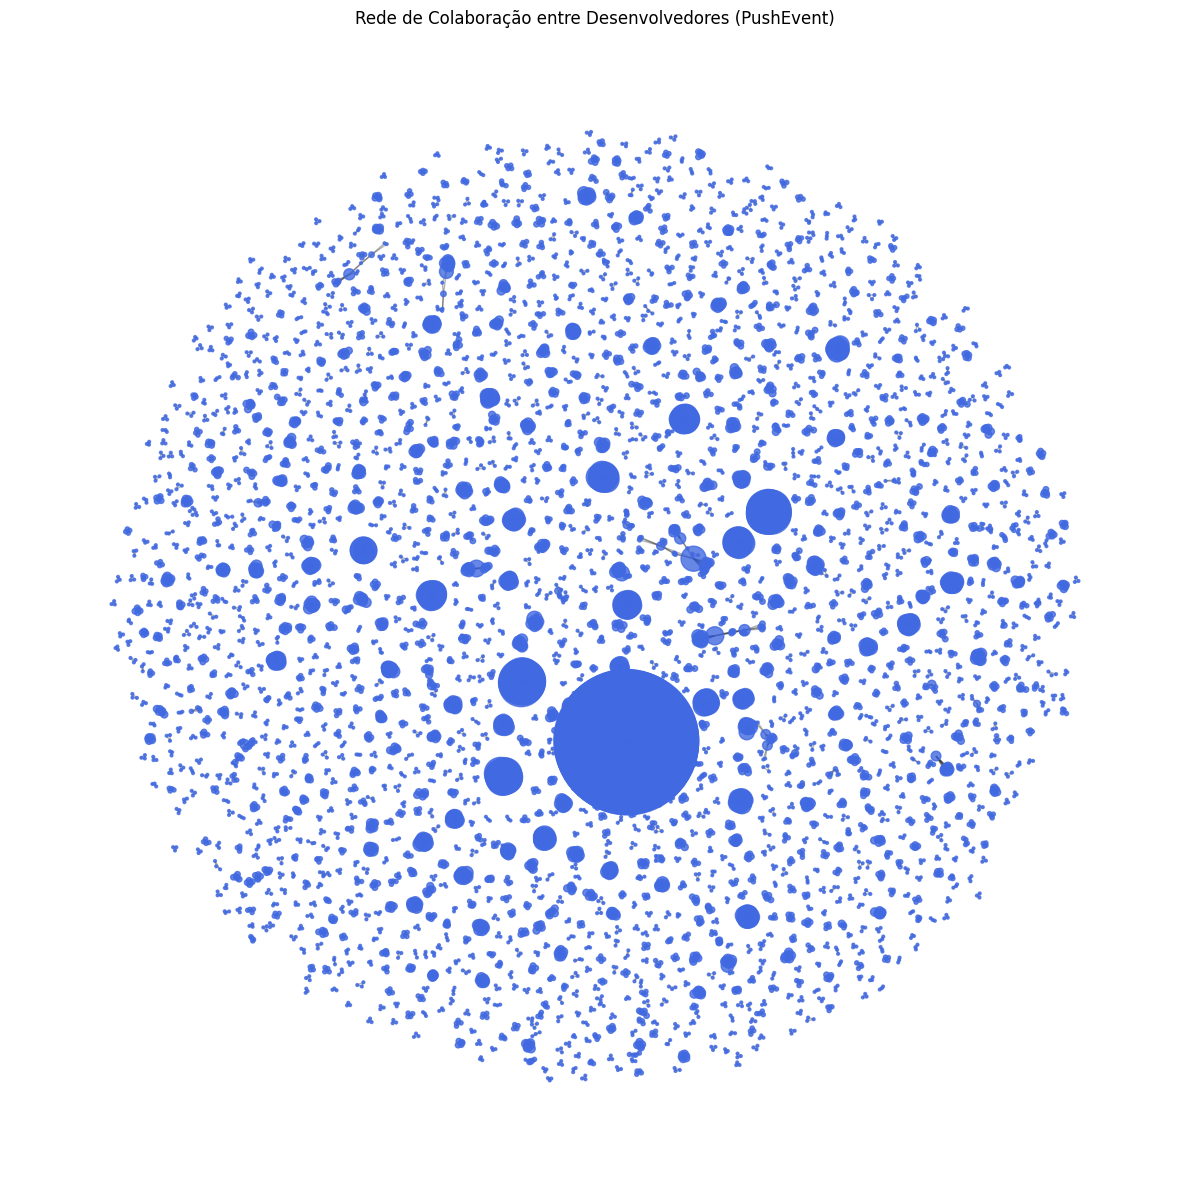

In [96]:
draw_graph(graph, degrees)

plt.title("Rede de Colaboração entre Desenvolvedores (PushEvent)")
plt.axis("off")
plt.tight_layout()
plt.savefig('./assets/rede-colaboracao-devs.png')

## 4. Análise estrutural

### Maior Componente Conexo (5 Devs desse componente)

In [100]:
largest_cc = max(nx.connected_components(graph), key=len)
subgraph = graph.subgraph(largest_cc)

degree_centrality = nx.degree_centrality(subgraph)
betweenness_centrality = nx.betweenness_centrality(subgraph)
closeness_centrality = nx.closeness_centrality(subgraph)

centrality_df = pd.DataFrame({
    "Usuário": list(degree_centrality.keys()),
    "Grau": list(degree_centrality.values()),
    "Intermediação": list(betweenness_centrality.values()),
    "Proximidade": list(closeness_centrality.values())
})

top5 = centrality_df.sort_values(by="Grau", ascending=False).head(5)
top5.reset_index(drop=True, inplace=True)
top5

,Usuário,Grau,Intermediação,Proximidade
0,depr-odoo,1.0,0.0,1.0
1,lvsz,1.0,0.0,1.0
2,plha-odoo,1.0,0.0,1.0
3,pavy-odoo,1.0,0.0,1.0
4,maedekey,1.0,0.0,1.0


### Densidade da rede

In [101]:
density_total = nx.density(graph)
density_subgraph = nx.density(subgraph)

print(f"Densidade da rede completa: {density_total:.5f}")
print(f"Densidade do maior componente: {density_subgraph:.5f}")

Densidade da rede completa: 0.00061
Densidade do maior componente: 1.00000


### Componentes conexos: quantidade e tamanhos

In [ ]:
components = list(nx.connected_components(graph))
component_sizes = [len(c) for c in components]
largest_size = max(component_sizes)
average_size = sum(component_sizes) / len(component_sizes)

print(f"Número de componentes conexos: {len(components)}")
print(f"Tamanho do maior componente: {largest_size}")
print(f"Tamanho médio dos componentes: {average_size:.2f}")


### Diâmetro e distância média (somente no maior componente)

In [102]:
if nx.is_connected(subgraph):
    diameter = nx.diameter(subgraph)
    avg_path_length = nx.average_shortest_path_length(subgraph)

    print(f"Diâmetro do maior componente: {diameter}")
    print(f"Comprimento médio dos caminhos: {avg_path_length:.2f}")
else:
    print("O maior subgrafo não é conexo.")


Diâmetro do maior componente: 1
Comprimento médio dos caminhos: 1.00


### Clustering (coeficiente de aglomeração)

In [103]:
avg_clustering = nx.average_clustering(graph)
top_clustering = nx.clustering(graph)

top5_clustering = sorted(top_clustering.items(), key=lambda x: x[1], reverse=True)[:5]
clustering_df = pd.DataFrame(top5_clustering, columns=["Usuário", "Coef. Clustering"])

print(f"Clustering médio da rede: {avg_clustering:.4f}")
clustering_df


Clustering médio da rede: 0.9953


,Usuário,Coef. Clustering
0,sunyeji,1.0
1,DH-C1,1.0
2,kookin09,1.0
3,ChunBae20,1.0
4,unity9Parkjaehyun,1.0


## 5. Aplicação de técnicas adicionais

### Detecção de Comunidades com o algoritmo de Louvain

Comunidades detectadas: 1


C:\Users\davif\AppData\Local\Temp\ipykernel_21500\1451516551.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', num_communities)


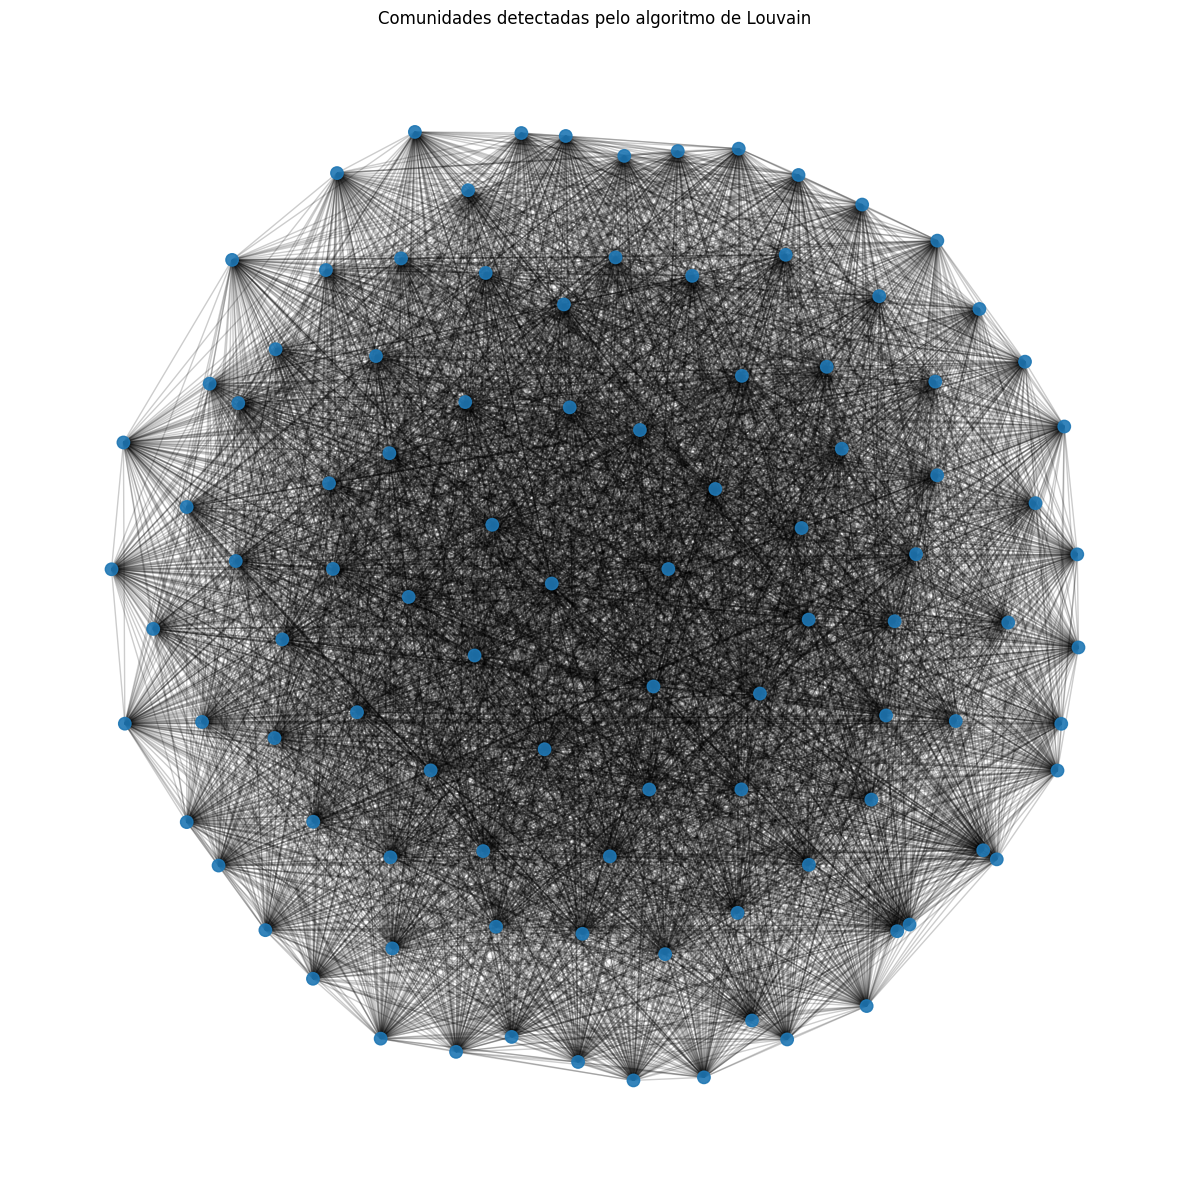

In [104]:
largest_cc = max(nx.connected_components(graph), key=len)
subgraph = graph.subgraph(largest_cc)

partition = community_louvain.best_partition(subgraph, weight='weight')

num_communities = len(set(partition.values()))
print(f"Comunidades detectadas: {num_communities}")

pos = nx.spring_layout(subgraph, seed=42)
cmap = cm.get_cmap('tab20', num_communities)

plt.figure(figsize=(12, 12))
nx.draw_networkx_nodes(
    subgraph,
    pos,
    partition.keys(),
    node_size=80,
    cmap=cmap,
    node_color=list(partition.values()),
    alpha=0.9
)
nx.draw_networkx_edges(subgraph, pos, alpha=0.2)
plt.title("Comunidades detectadas pelo algoritmo de Louvain")
plt.axis('off')
plt.tight_layout()
plt.savefig('./assets/comunidades_louvain.png')
plt.show()

## 6. Discussão e conclusões

### Respostas das Perguntas

1. Quais desenvolvedores colaboram com mais frequência com outros em projetos públicos? -> Cód

In [ ]:
def desenvolvedores_com_mais_conexoes(G, top_n=5):
    graus = dict(G.degree())
    mais_conectados = sorted(graus.items(), key=lambda x: x[1], reverse=True)
    return mais_conectados[:top_n]

In [ ]:
devs_grau = desenvolvedores_com_mais_conexoes(graph)
print("\nMais conectados por número de pessoas:")
for dev, grau in devs_grau:
    print(f"{dev} - {grau} desenvolvedores diferentes")


2. Existem padrões visuais que indicam silos ou isolamento de certos grupos de desenvolvedores? -> Grafo

Sim, observando o grafo da rede de colaboração dos Devs, é possível observar que basicamente as conexões são formadas por silos ou isolamento de grupos.

3. Existem padrões visuais que sugerem estrutura hierárquica, como redes em estrela, árvores ou galhos? -> Grafo

Possivelmente sim, porém aparentam ser poucos os casos de grupos que sugerem a estrutura hierárquica, somente caso for analisado mais profundo grupos por grupos pela nossa rede ser isolada.
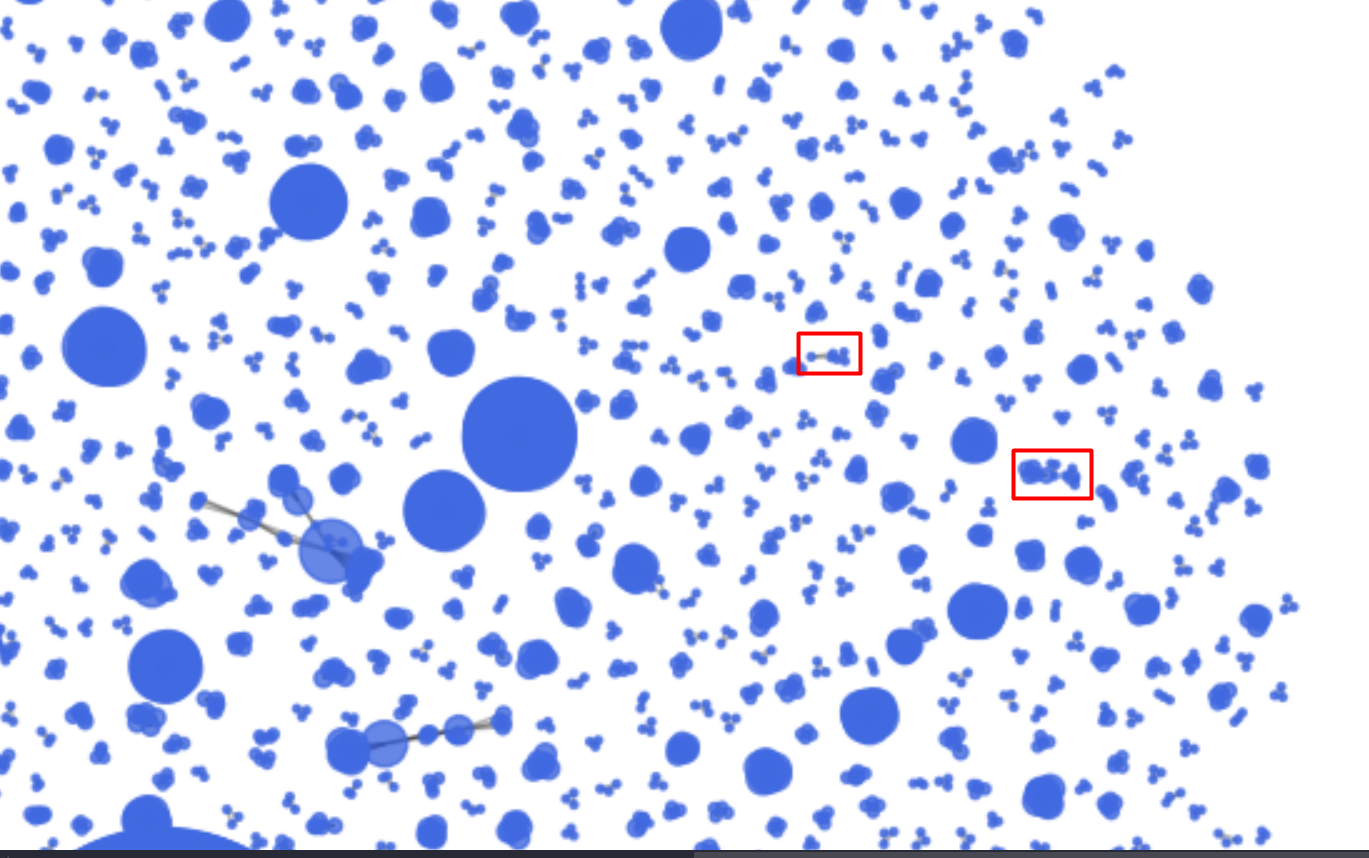

4. Existem desenvolvedores que funcionam como “ponte” entre grupos distintos? -> Grafo

Pelo que foi analisado existem sim desenvolvedores que funcionam como ponte entre grupos distintos como é possível observar no print, as comunidades não possuem muita relação entre si, logo um desenvolvedor fez uma conexão entre elas.
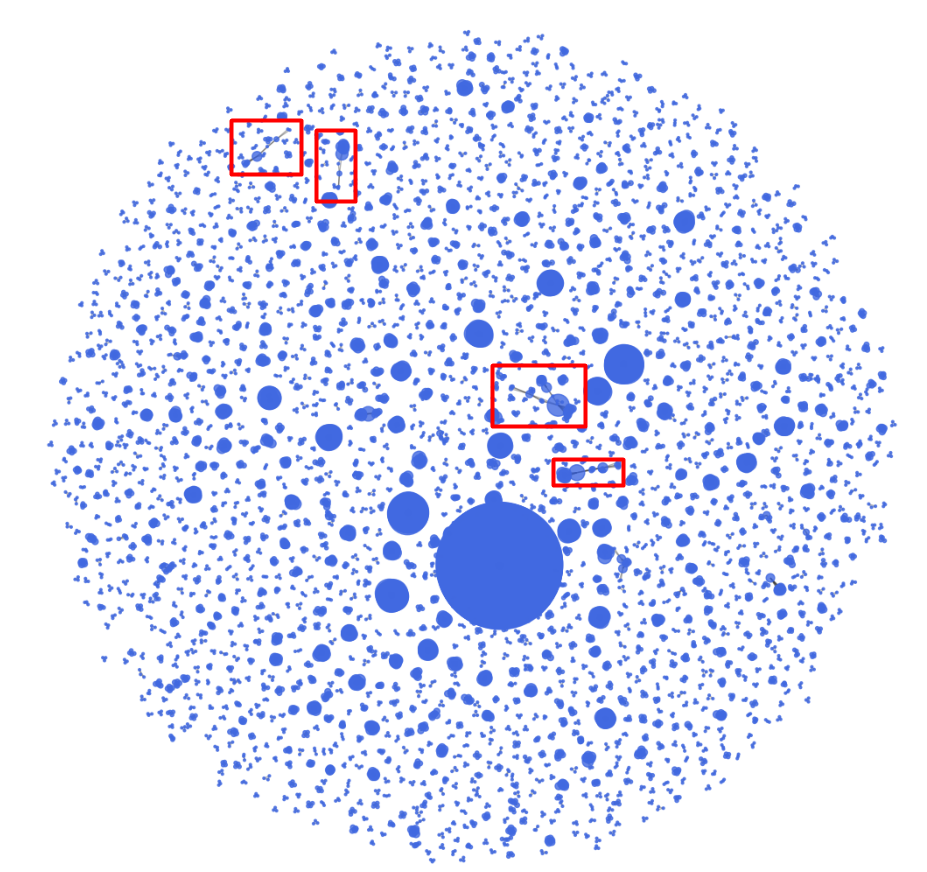

5. Quais pares de desenvolvedores mais colaboraram em projetos públicos? -> Cód

In [ ]:
def maiores_colaboradores(grafo, top_n=5):
    arestas = list(grafo.edges(data=True))
    mais_colaboraram = sorted(arestas, key=lambda x: x[2]['weight'], reverse=True)
    
    return mais_colaboraram[:top_n]

In [ ]:
top_colabs = maiores_colaboradores(graph)
print("Pares que mais colaboraram:")
for u1, u2, data in top_colabs:
    print(f"{u1} ↔ {u2} — {data['weight']} colaborações")
